# Superstore Marketing Campaign Dataset

## Business Context 

The marketing team wanted to promote a discounted Gold Membership — offering a 20% discount on all purchases for \\$499 instead of the normal pricing of \\$999. To minimize campaign costs, leadership requested a predictive model to classify which existing customers were most likely to purchase the offer.

**Objectives:**
* Predict the likelihood of a customer purchasing the Gold Membership
* Identify key features that drive positive purchase responses
* Generate a prioritized call list of high-potential customers for the outbound campaign

Kaggle Project: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset

## Analytical Approach
---
1. Exploratory Analysis
2. Data Cleaning
3. Feature Prep
4. Data Splitting
5. Create Baseline Model
6. Optimize Model & Final Model Summary
7. Export Data for Calling Campaign
8. Executive Report

## Section 1: Exploratory Analysis

---

**Section Objectives:**
*   Load dataset & inspect shape, datatypes, sample rows
*   Check target variable distribution (class balance)
*   Note data sources, time periods, and potential leakage risks



In [1]:
import pandas as pd

# Import data from github repository
url = "https://raw.githubusercontent.com/Analyst-KatieD/kaggle-superstore-marketing/main/superstore_data.csv"
df = pd.read_csv(url)

# Display the first few rows to confirm it loaded correctly
df.head()


,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1501,1982,PhD,Married,160803.0,0,0,2012-04-08,21,55,...,17,3,4,15,0,28,1,0,0,0
1,8475,1973,PhD,Married,157243.0,0,1,2014-01-03,98,20,...,1,2,1,15,0,22,0,0,0,0
2,8720,1978,2n Cycle,Together,NaN,0,0,2012-12-08,53,32,...,12,4,22,0,0,0,1,0,0,0
3,5555,1975,Graduation,Divorced,153924.0,0,0,2014-07-02,81,1,...,1,1,1,0,0,0,0,0,0,0
4,11181,1949,PhD,Married,156924.0,0,0,2013-08-29,85,2,...,1,1,1,0,0,0,0,0,0,0


In [2]:
import numpy as np #more numeric formulas
import matplotlib.pyplot as plt #for nice histograms
import seaborn as sns #for boxplots and heat map
from statsmodels.formula.api import logit #to build the regression model
import scipy.stats as stats #to calculate z-score
import missingno as msno #to visualize missing values
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm #for residual plots
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
# Convert the object column to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d')

# Check the result
print(df['Dt_Customer'].dtype)
df['Dt_Customer'].head()

datetime64[ns]


0   2012-04-08
1   2014-01-03
2   2012-12-08
3   2014-07-02
4   2013-08-29
Name: Dt_Customer, dtype: datetime64[ns]

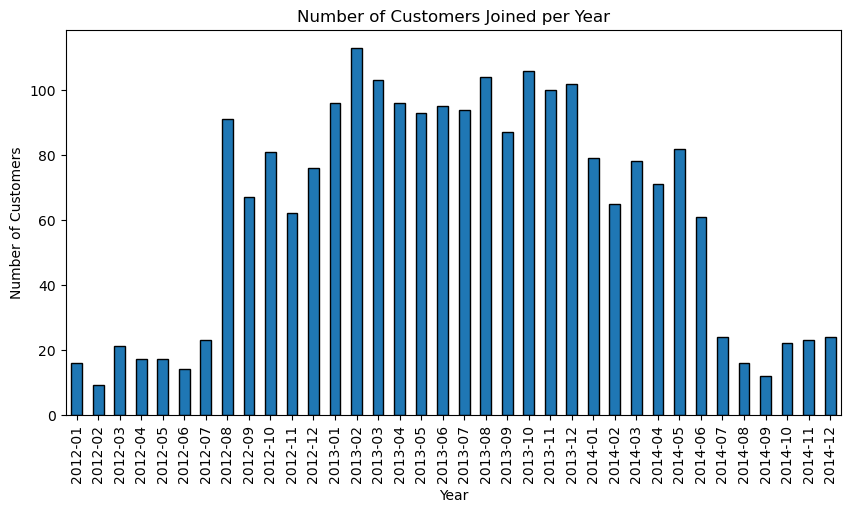

In [8]:
# Format: YYYY-MM
df['Join_YearMonth'] = df['Dt_Customer'].dt.to_period('M')

# Count customers per year-month
join_counts = df['Join_YearMonth'].value_counts().sort_index()

plt.figure(figsize=(10,5))
join_counts.plot(kind='bar', edgecolor='k')
plt.title('Number of Customers Joined per Year')
plt.xlabel('Year')
plt.ylabel('Number of Customers')
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

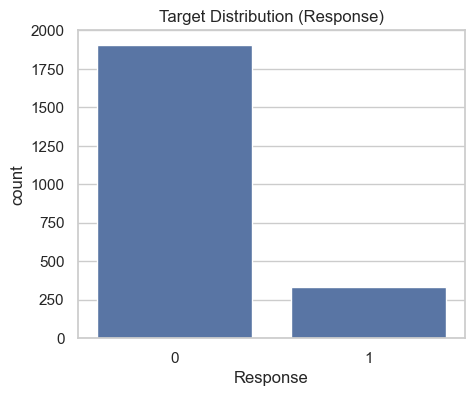

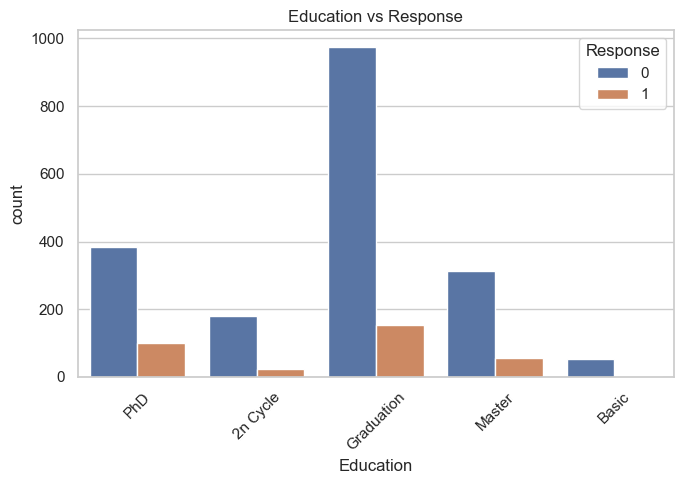

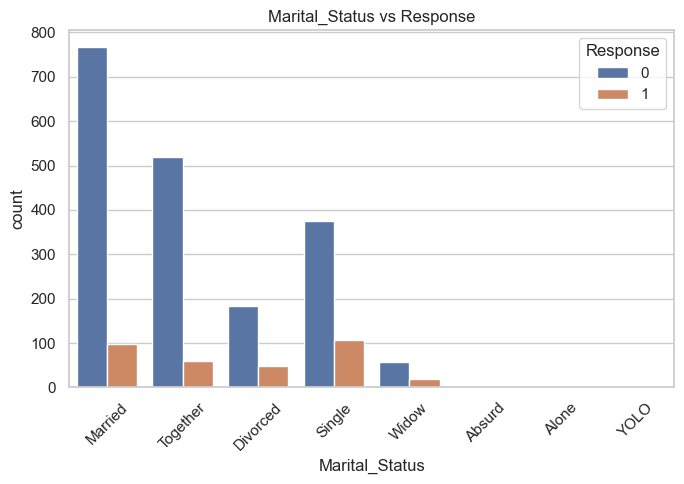

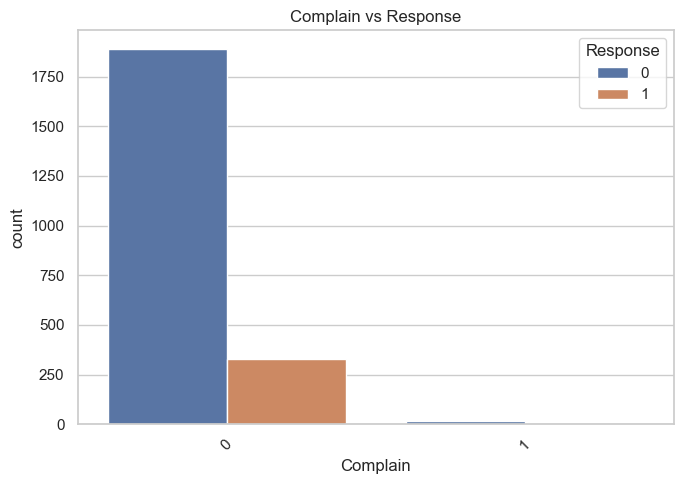

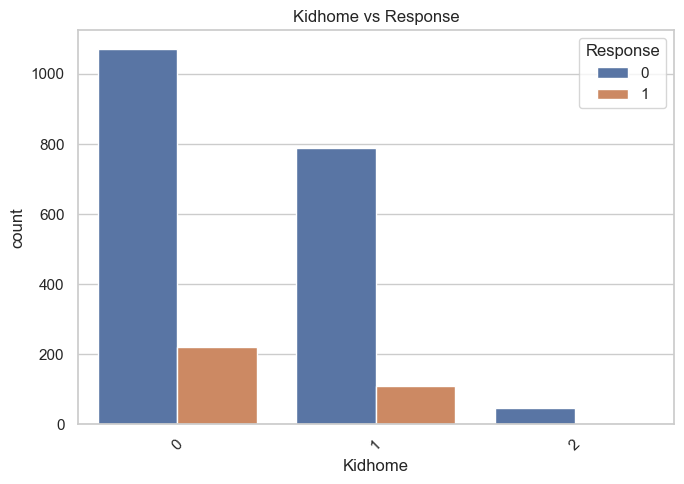

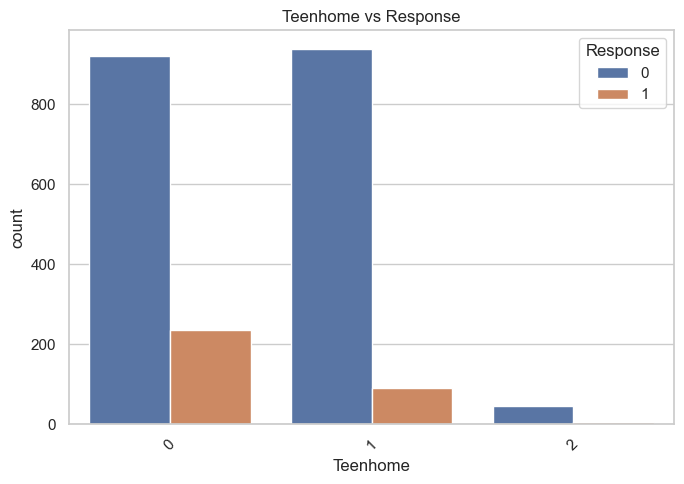

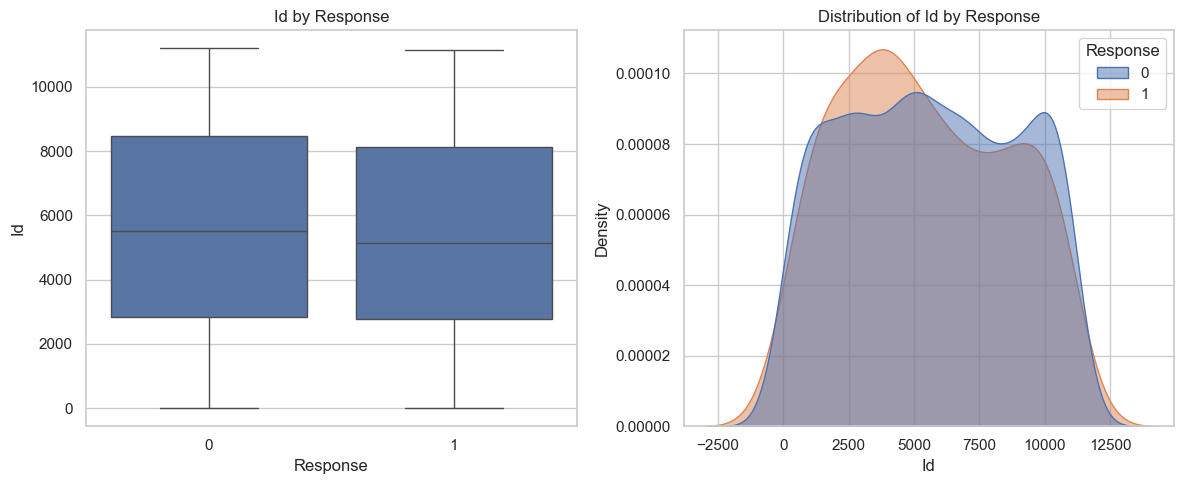

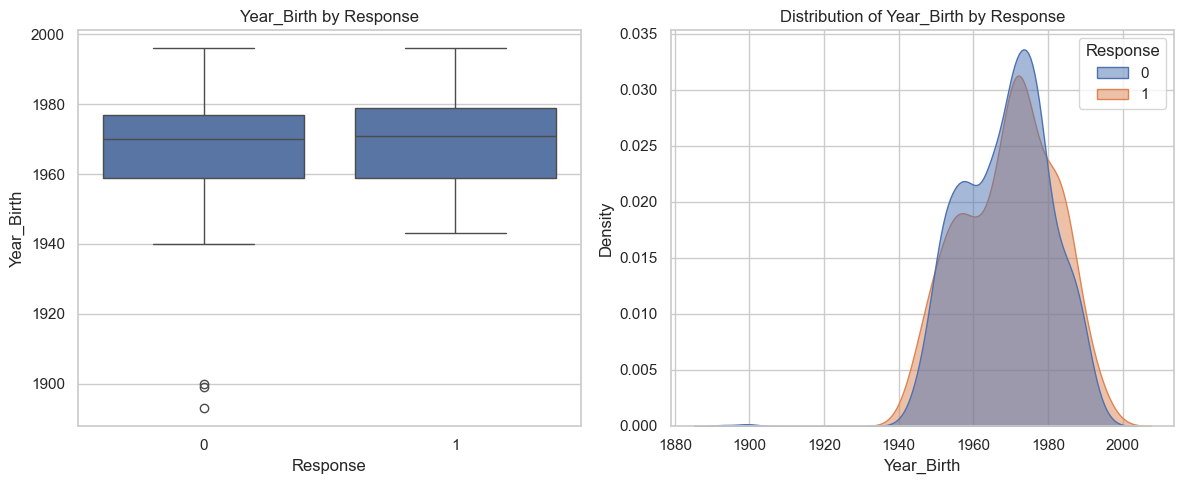

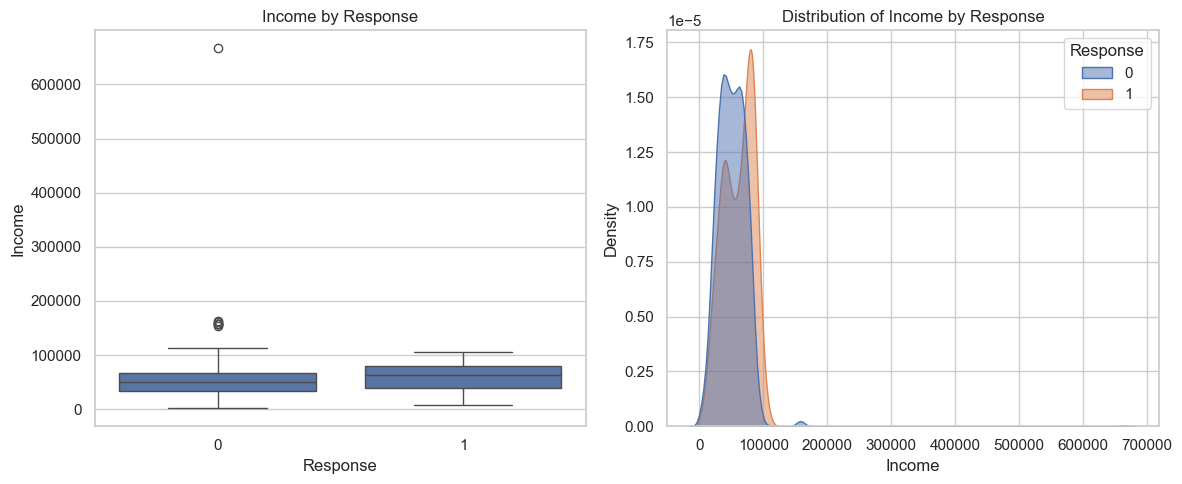

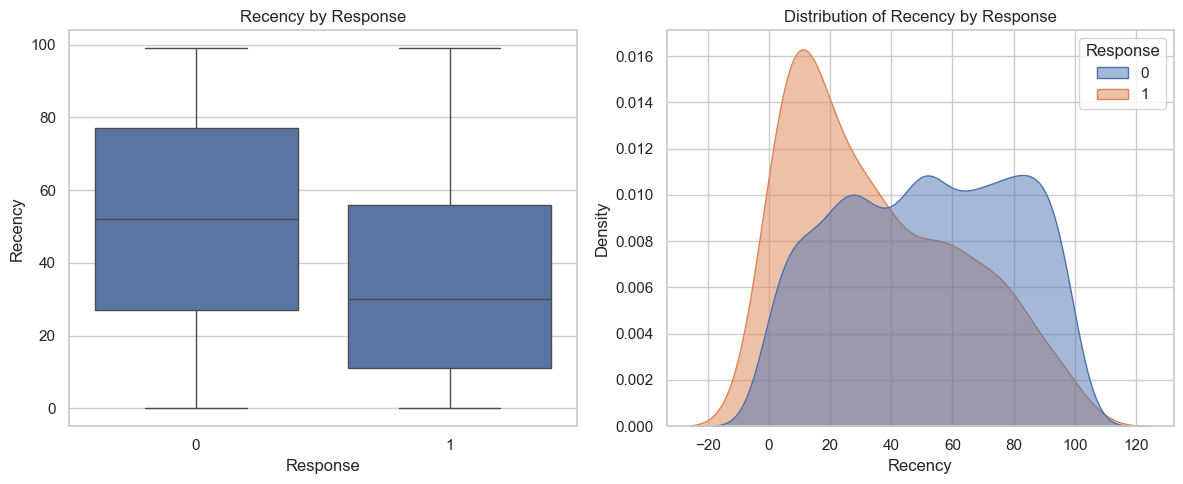

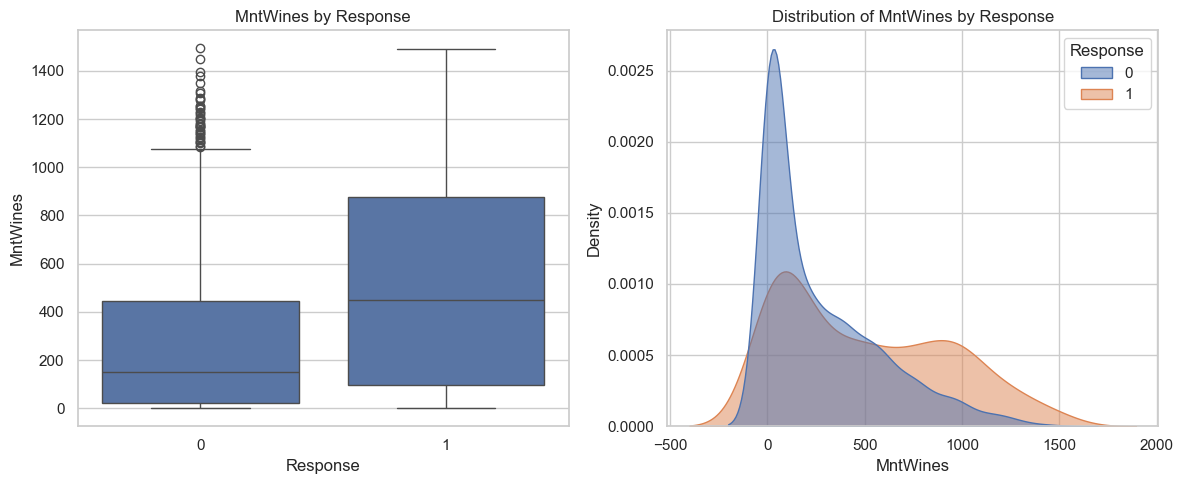

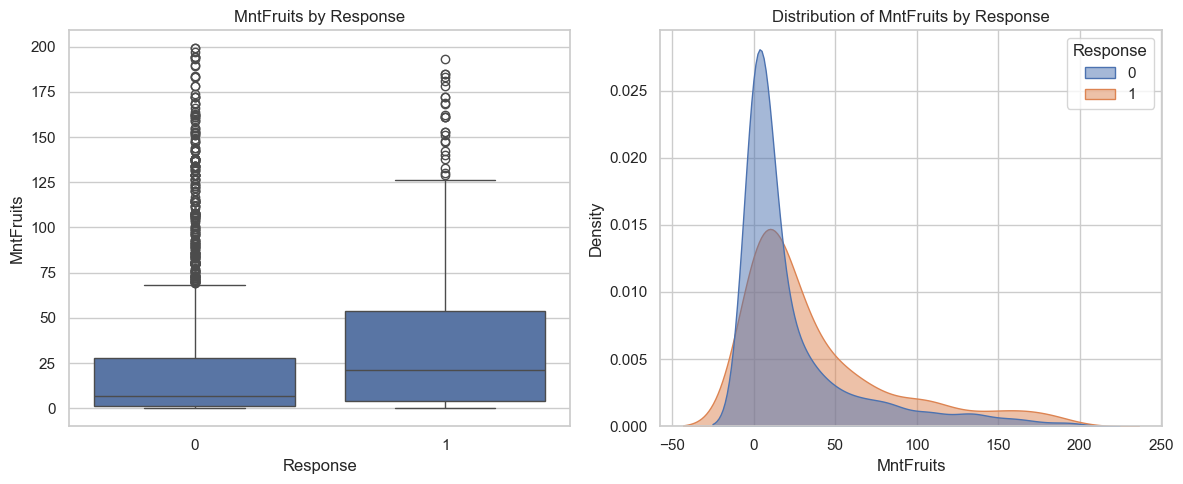

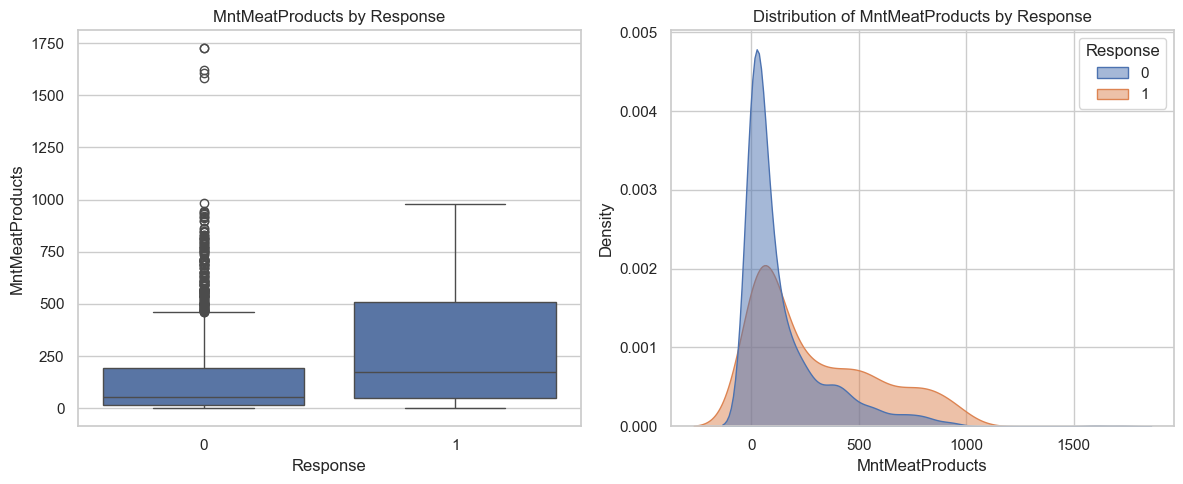

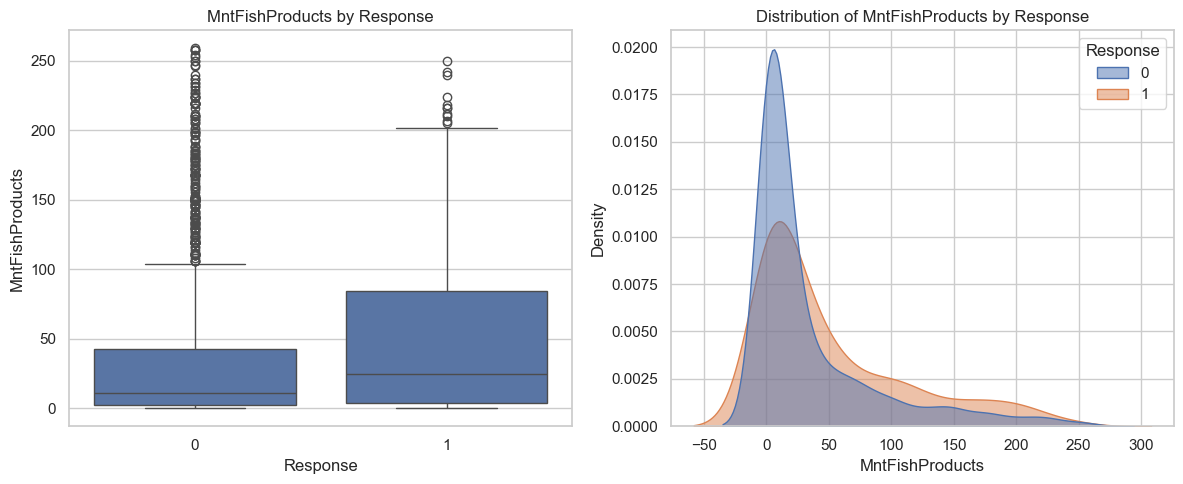

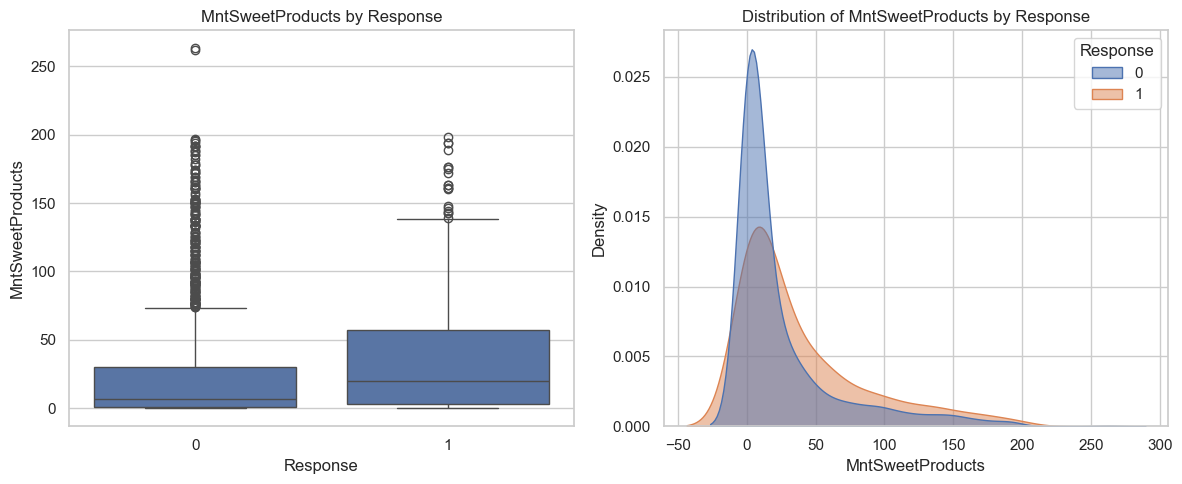

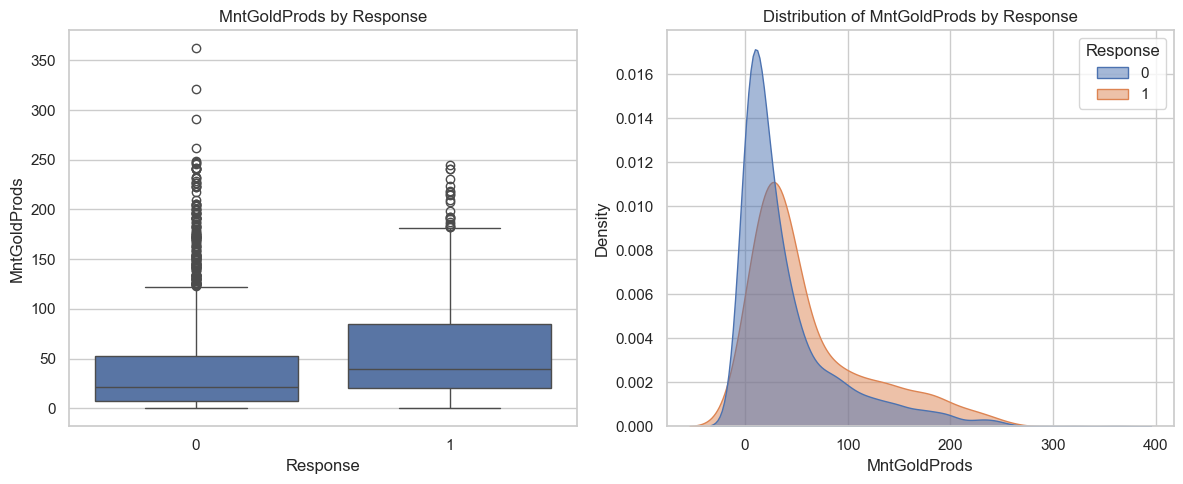

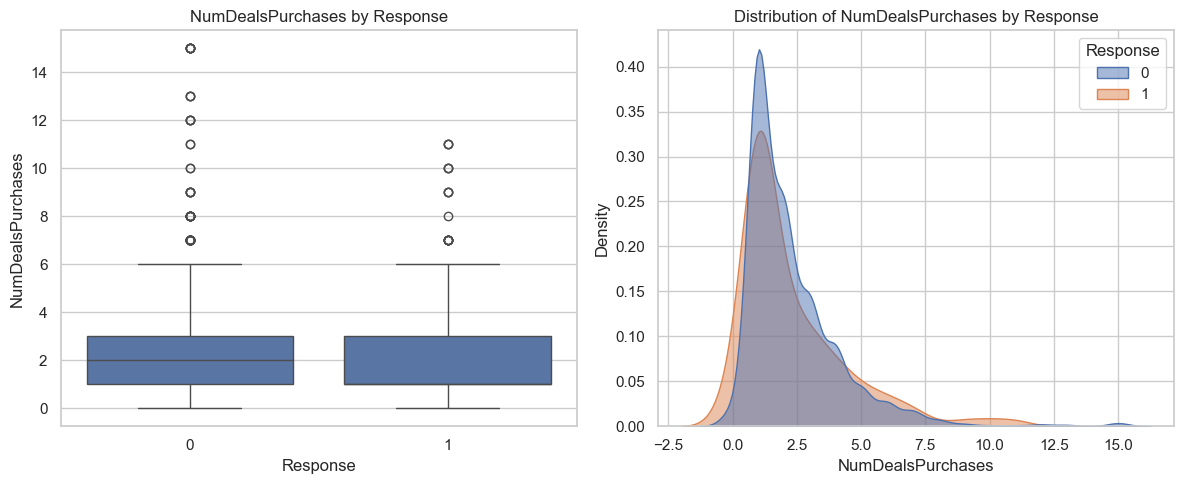

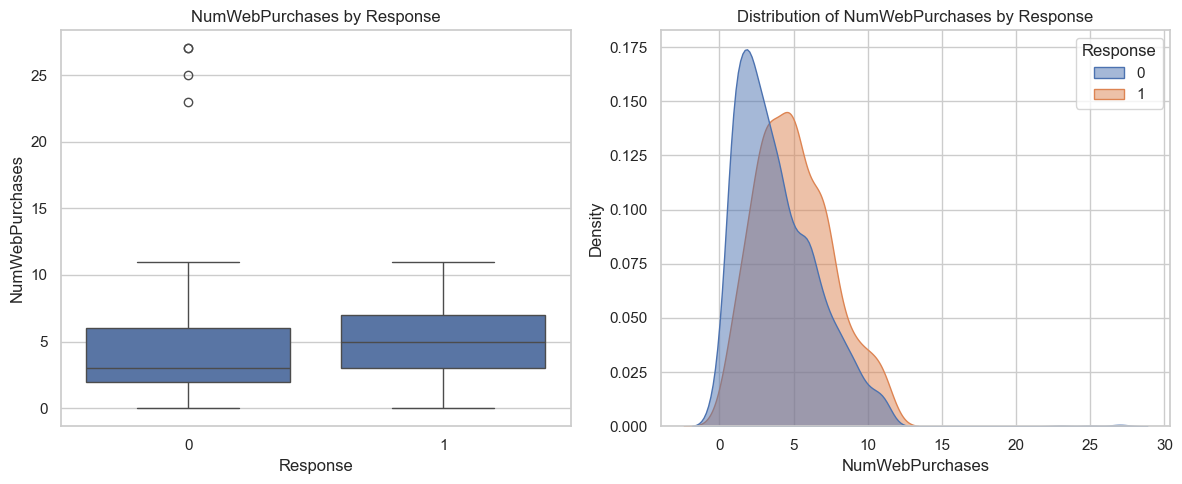

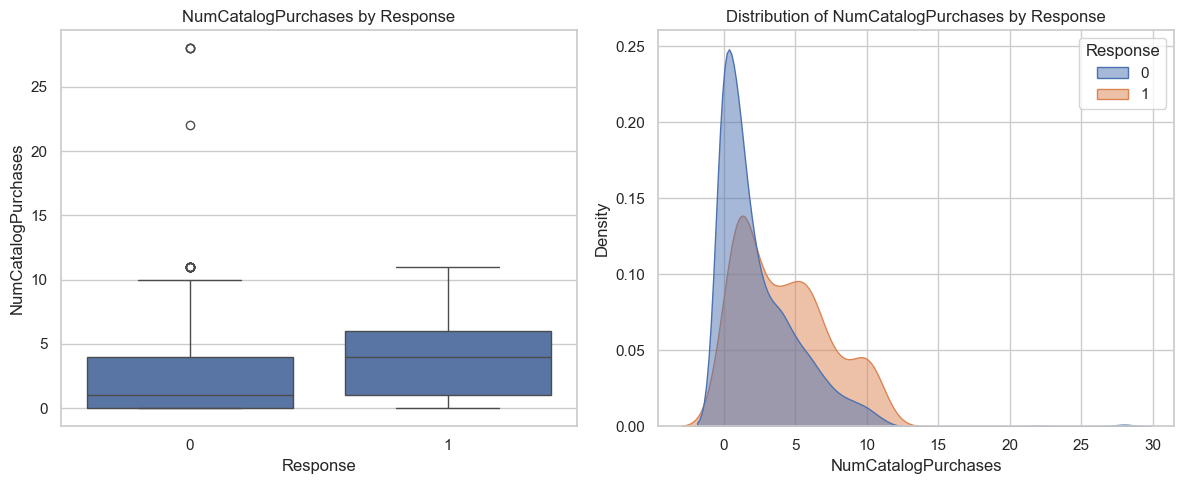

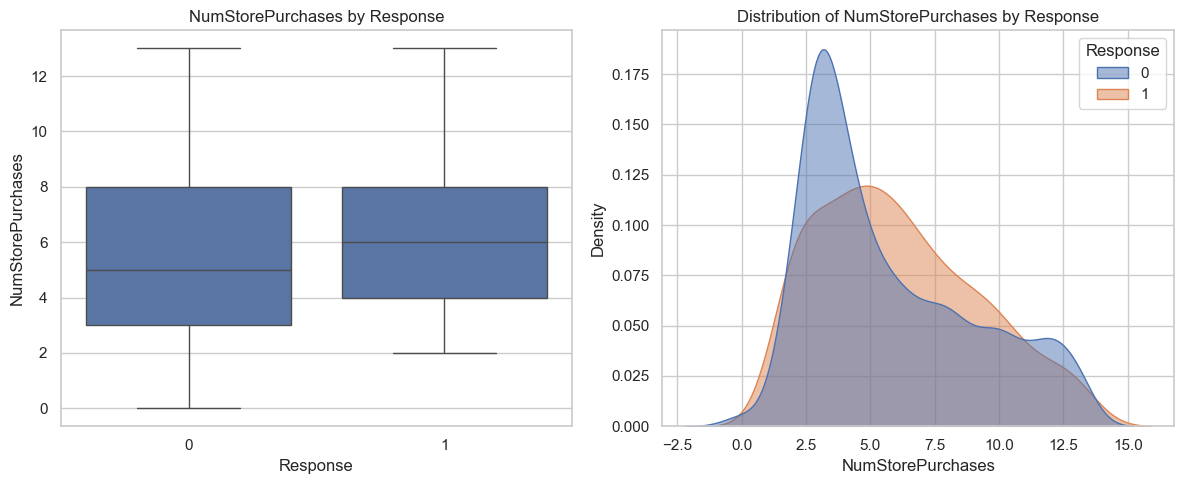

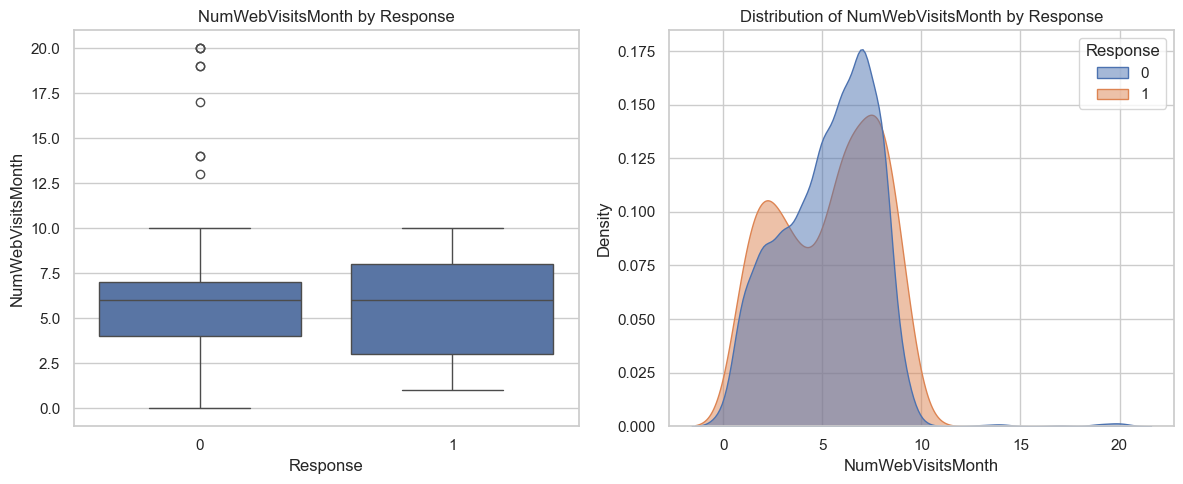

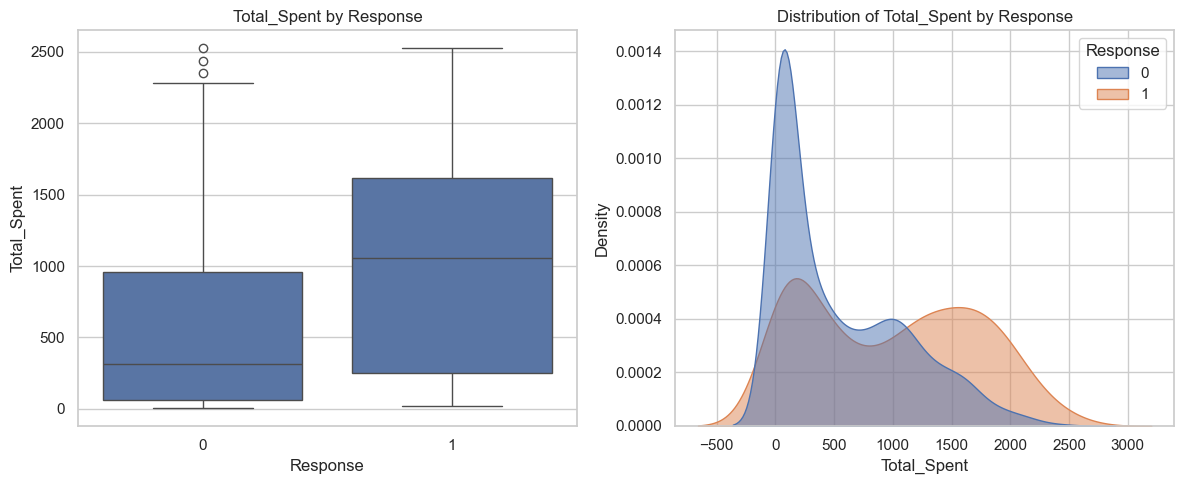

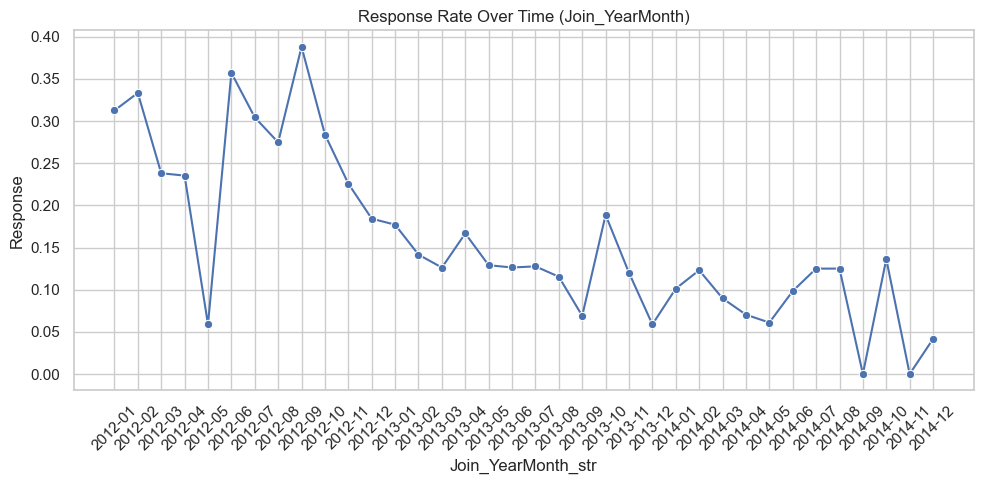

In [22]:
# Set style
sns.set(style="whitegrid")

# -------------------------------------------------
# Identify column types
# -------------------------------------------------
target = "Response"

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
categorical_cols += ["Complain", "Kidhome", "Teenhome"]  # small int categorical
categorical_cols = [col for col in categorical_cols if col in df.columns and col != target]

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in [target, "Complain", "Kidhome", "Teenhome"]]

time_cols = ["Join_YearMonth"] if "Join_YearMonth" in df.columns else []

# -------------------------------------------------
# 1. TARGET DISTRIBUTION
# -------------------------------------------------
plt.figure(figsize=(5,4))
sns.countplot(data=df, x=target)
plt.title("Target Distribution (Response)")
plt.show()

# -------------------------------------------------
# 2. CATEGORICAL VS TARGET
# -------------------------------------------------
for col in categorical_cols:
    plt.figure(figsize=(7,5))
    sns.countplot(data=df, x=col, hue=target)
    plt.title(f"{col} vs {target}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# 3. NUMERIC VS TARGET (Boxplots + KDE)
# -------------------------------------------------
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # Boxplot
    sns.boxplot(data=df, x=target, y=col, ax=axes[0])
    axes[0].set_title(f"{col} by {target}")

    # KDE Plot
    sns.kdeplot(data=df, x=col, hue=target, fill=True, common_norm=False, alpha=0.5, ax=axes[1])
    axes[1].set_title(f"Distribution of {col} by {target}")

    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# 4. TIME-BASED RELATIONSHIP (Join_YearMonth)
# -------------------------------------------------
if "Join_YearMonth" in df.columns:
    df_time = df.copy()
    df_time["Join_YearMonth_str"] = df_time["Join_YearMonth"].astype(str)

    trend = (
        df_time.groupby("Join_YearMonth_str")["Response"]
        .mean()
        .reset_index()
        .sort_values("Join_YearMonth_str")
    )

    plt.figure(figsize=(10,5))
    sns.lineplot(data=trend, x="Join_YearMonth_str", y="Response", marker="o")
    plt.title("Response Rate Over Time (Join_YearMonth)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



### Section 1 Overview:
In the 2 categorical text fields there are weird options that likely should be dropped from the analysis.

## Section 2: Data Cleaning
---


*   Remove duplicates & invalid rows
*   Correct data types (numeric, categorical, datetime)
*   Handle missing values
    *   Compute % missing per column
    *   Decide drop vs. impute
    *   Add “missing flag” columns if useful
*   Detect & treat outliers (IQR / z-score / domain rules)
*   Standardize categorical labels (case, spacing, typos)
*   Combine rare categories (“Other”)
*   Check and fix inconsistent encodings (Yes/No vs. 1/0)

In [ ]:
#  Check for Duplicate Rows
df.duplicated(['Id']).value_counts()

No duplicate entries to clean

In [ ]:
# Update Categorical strings to update the weird responses to an unknown option
# Education:  2n Cycle >> Unknown
# Marital_Status: Yolo, Absurd >> Unknown,  Alone >> Single, Together >> Married
# df['col'] = df['col'].replace({'ny': 'new york', 'n.y.': 'new york'})

df['Education'] = df['Education'].replace({'2n Cycle': 'Unknown'})
df['Marital_Status'] = df['Marital_Status'].replace({'YOLO':'Unknown', 'Absurd':'Unknown', 'Alone':'Single', 'Together':'Married'})

In [ ]:
sns.catplot(x='Education', kind='count', data=df, height=4, aspect=2)
plt.title('Count of Observations per Option')
plt.xlabel('Education')
plt.ylabel('Count')
plt.show()

In [ ]:
sns.catplot(x='Marital_Status', kind='count', data=df, height=4, aspect=2)
plt.title('Count of Observations per Option')
plt.xlabel('Marital_Status')
plt.ylabel('Count')
plt.show()

In [ ]:
# Generate a matrix plot to review for missing values
msno.matrix(df)

Income is only field with missing values.  

In [ ]:
plt.boxplot(df['Income'].dropna(), vert=False)
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
values, bins, bars = plt.hist(df['Income'], bins=10, edgecolor='white', range =(0,175000))
plt.title('Income')
plt.margins(x=0.1, y=0.1)
plt.bar_label(bars)
plt.show()

In [ ]:
df['Income'].describe()

In [ ]:
median_income = float(np.median(df['Income'].dropna()))
median_income

In [ ]:
df['Income'] = df['Income'].fillna(median_income)

df['Income'].info()

In [ ]:
df['Income'].describe()

#### Combine all of the 'Spending' Columns into a total spent

In [16]:
spending_cols = ['MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spent'] = df[spending_cols].sum(axis=1)
print(df[['Total_Spent', 'MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].head(10))


   Total_Spent  MntWines  MntMeatProducts  MntFruits  MntFishProducts  \
0         1717        55             1622         16               17   
1         1608        20             1582          2                1   
2         1679        32             1607          2               12   
3            6         1                1          1                1   
4            8         2                2          1                1   
5          416        81               33          4                5   
6         1423       494              391         92              194   
7         1263       493              352        183              184   
8         1165       376              462         53              168   
9          926       318              407          8              150   

   MntSweetProducts  MntGoldProds  
0                 3             4  
1                 2             1  
2                 4            22  
3                 1             1  
4               

In [ ]:
df.drop(columns=['MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], inplace=True)

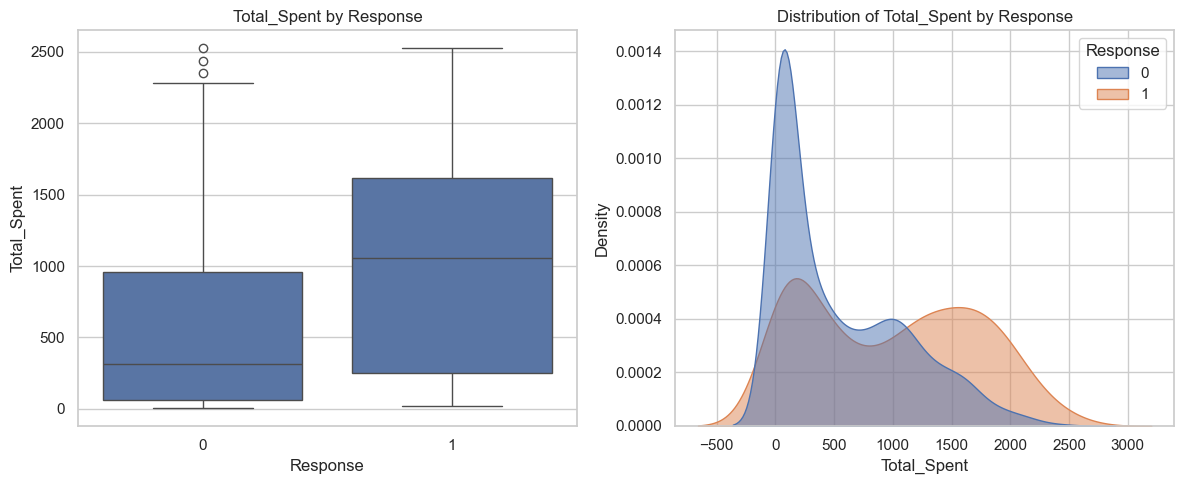

In [19]:
plt.figure(figsize=(12,5))

# --- Boxplot ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x="Response", y="Total_Spent")
plt.title("Total_Spent by Response")

# --- KDE Plot ---
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x="Total_Spent", hue="Response", fill=True, common_norm=False, alpha=0.5)
plt.title("Distribution of Total_Spent by Response")

plt.tight_layout()
plt.show()

#### Combine all the purchases into 1 variable

In [ ]:
purchases_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Purchases'] = df[purchases_cols].sum(axis=1)
print(df[['Total_Purchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].head(10))


In [ ]:
df.drop(columns=['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], inplace=True)


In [ ]:
plt.figure(figsize=(12,5))

# --- Boxplot ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x="Response", y="Total_Purchases")
plt.title("Total_Purchases by Response")

# --- KDE Plot ---
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x="Total_Spent", hue="Response", fill=True, common_norm=False, alpha=0.5)
plt.title("Distribution of Total_Purchases by Response")

plt.tight_layout()
plt.show()


#### Check and fix outliers 

In [ ]:
# Save a copy of the df before outlier detection and replacement 
df_original = df.copy() 

In [ ]:
# Columns to ignore
ignore_cols = ['Response', 'Marital_Status', 'Education', 'Id', 'Complain', 'Kidhome', 'Teenhome']

# Numeric columns to process
num_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in ignore_cols]

# Loop through each numeric column
for col in num_cols:
    # Copy column for "before" boxplot
    before = df[col].copy()
    
    # Calculate IQR bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Define caps at 5th and 95th percentiles
    low_cap = df[col].quantile(0.05)
    high_cap = df[col].quantile(0.95)
    
    # Count outliers before replacement
    num_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    
    # Replace outliers
    df[col] = df[col].apply(lambda x: low_cap if x < lower else high_cap if x > upper else x)
    
    # Copy column for "after" boxplot
    after = df[col]
    
    # Print summary
    print(f"{col}: {num_outliers} outliers replaced")
    
    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].boxplot(before)
    axes[0].set_title(f"{col} - Before Outlier Handling")
    
    axes[1].boxplot(after)
    axes[1].set_title(f"{col} - After Outlier Handling")
    
    plt.show()


## 3. Feature Preparation

*   Transform skewed numeric variables (log/sqrt if needed)
*   Create derived features (ratios, bins, interactions if justified)
*   Encode categorical variables
    *   One-hot for nominal
    *   Ordinal encoding for ordered categories
*   Scale numeric features (standard or robust scaling)
*   Check correlations & VIF for multicollinearity
*   Drop or combine highly correlated features

### Transform Numeric Variables

*   Evaluate for skew
*   Evaluate for scale
*   Transform both as needed 
*   Report changes 

In [ ]:
# Save a copy of the df before transformed skewed variables
df_outlier = df.copy() 

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

def preprocess_numeric(df, ignore_cols=None, skew_threshold=1.0, transformation='log', scaling='standard'):
    """
    Handle skewed numeric features and scale them for modeling.

    Parameters:
    - df: pandas DataFrame
    - ignore_cols: list of columns to skip (e.g., target, booleans)
    - skew_threshold: absolute skewness above which to transform
    - transformation: 'log', 'sqrt', or 'boxcox'
    - scaling: 'standard' or 'robust'

    Returns:
    - df_scaled: DataFrame with transformed and scaled numeric features
    """
    if ignore_cols is None:
        ignore_cols = []

    # Select numeric columns to process
    num_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in ignore_cols]

    # Initialize scaler
    if scaling == 'standard':
        scaler = StandardScaler()
    elif scaling == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("scaling must be 'standard' or 'robust'")

    df_scaled = df.copy()
    
    for col in num_cols:
        data_before = df_scaled[col].copy()
        skewness_before = data_before.skew()
        transformation_applied = "None"

        # Transform if skewed
        if abs(skewness_before) > skew_threshold:
            if transformation == 'log':
                if (data_before <= 0).any():
                    df_scaled[col] = np.log1p(data_before)  # log(1+x) handles zeros
                    transformation_applied = "log1p"
                else:
                    df_scaled[col] = np.log(data_before)
                    transformation_applied = "log"
            elif transformation == 'sqrt':
                df_scaled[col] = np.sqrt(data_before.clip(lower=0))
                transformation_applied = "sqrt"
            elif transformation == 'boxcox':
                if (data_before <= 0).any():
                    transformation_applied = "Box-Cox not applied (non-positive values)"
                else:
                    df_scaled[col], _ = stats.boxcox(data_before)
                    transformation_applied = "Box-Cox"
        else:
            df_scaled[col] = data_before  # no transformation

        # Scale the column
        df_scaled[col] = scaler.fit_transform(df_scaled[[col]])

        # Plot before and after histograms
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.hist(data_before, bins=30, edgecolor='k', alpha=0.7)
        plt.title(f"{col} - Before\nSkewness: {skewness_before:.2f}")

        plt.subplot(1,2,2)
        plt.hist(df_scaled[col], bins=30, edgecolor='k', alpha=0.7)
        plt.title(f"{col} - After ({transformation_applied}, {scaling} scaled)")
        plt.show()

        print(f"{col}: Transformation -> {transformation_applied}, Scaling -> {scaling}")
        print("-"*60)
    
    return df_scaled


In [ ]:
df_preprocessed = preprocess_numeric(df, ignore_cols=ignore_cols, transformation='log', scaling='standard')

### Encode Categorical Columns

In [ ]:
df = df_preprocessed.copy() 
df.head()

In [ ]:
# Change the dt_customer field to bins so the logistic model is able to use this data effectively
df['Customer_Tenure_Bin'] = pd.cut(
    df['Dt_Customer'],
    bins=pd.to_datetime(['2012-01-01','2012-06-30','2012-12-31',
                         '2013-06-30','2013-12-31','2014-06-30','2014-12-31']),
    labels=['H1 2012','H2 2012','H1 2013','H2 2013','H1 2014','H2 2014']
)

df['Customer_Tenure_Bin'].head()


In [ ]:
sns.catplot(x='Customer_Tenure_Bin', kind='count', data=df, height=4, aspect=2)
plt.title('Count of Observations per Option')
plt.xlabel('Customer_Tenure_Bin')
plt.ylabel('Count')
plt.show()

In [ ]:
df.drop(columns=['Dt_Customer', 'Join_YearMonth'], inplace=True)
df.info()

In [ ]:
# Update the field Year_Birth to bins
# Compute age as of 2015
df['Age'] = 2015 - df['Year_Birth']

# Define age bins and labels
bins = [0, 24, 34, 44, 54, 64, float('inf')]  # last bin = 65+
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Bin the ages
df['Age_Bin'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# Verify
print(df[['Year_Birth', 'Age', 'Age_Bin']].head(10))
 

In [ ]:
sns.catplot(x='Age_Bin', kind='count', data=df, height=4, aspect=2)
plt.title('Count of Observations per Option')
plt.xlabel('Age_Bin')
plt.ylabel('Count')
plt.show()

In [ ]:
df.drop(columns=['Year_Birth', 'Age'], inplace=True)
df.info()

In [ ]:
# Detect categorical columns automatically
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns detected for encoding: {cat_cols}")

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Check the result
print(f"Shape before encoding: {df.shape}")
print(f"Shape after encoding: {df_encoded.shape}")
df_encoded.head()


In [ ]:
df_encoded['Response'] = df_encoded['Response'].astype(bool)
df_encoded['Complain'] = df_encoded['Complain'].astype(bool)

# Verify the changes
print(df_encoded[['Response', 'Complain']].dtypes)
df_encoded[['Response', 'Complain']].head()

In [ ]:
df_encoded.info()

### Correlations & Multicollinearity 


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def correlation_and_vif(df, target_col, vif_threshold=5.0):
    """
    Computes correlation with target and VIF for numeric features.
    
    Parameters:
    - df: pandas DataFrame
    - target_col: name of target column
    - vif_threshold: threshold to flag high multicollinearity
    
    Returns:
    - report_df: DataFrame with feature, correlation with target, VIF, and multicollinearity flag
    """
    # 1. Separate features from target
    feature_cols = [col for col in df.columns.drop(target_col) if df[col].var() > 0]
    X = df[feature_cols].copy().astype(float)

    y = df[target_col]
    
    # 2. Correlation with target
    corr_with_target = X.corrwith(y)
    
    # 3. Compute VIF
    vif_values = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # 4. Compile report
    report_df = pd.DataFrame({
        'Feature': feature_cols,
        'Correlation_with_Target': corr_with_target,
        'VIF': vif_values
    })
    
    # Flag high multicollinearity
    report_df['High_VIF'] = report_df['VIF'] > vif_threshold
    
    # Sort by absolute correlation descending
    report_df = report_df.reindex(report_df['Correlation_with_Target'].abs().sort_values(ascending=False).index)
    
    # Print summary
    print("Correlation and VIF Report (sorted by |correlation|):\n")
    print(report_df.to_string(index=False))
    print(f"\nFeatures with VIF > {vif_threshold} are flagged as 'High_VIF=True'.")
    
    return report_df


In [ ]:
# Assuming df_encoded is your processed DataFrame
report = correlation_and_vif(df_encoded, target_col='Response', vif_threshold=5.0)


Column Income will be dropped to help with multicollinearity

In [ ]:
# Drop Income column
df_encoded.drop(columns=['Income'], inplace=True)

# Optional: re-run correlation and VIF to confirm
report2 = correlation_and_vif(df_encoded, target_col='Response', vif_threshold=5.0)


In [ ]:
df_encoded.info()

## 4. Data Splitting
   * Split dataset into train/test before target-informed steps
   * Use stratified split for classification
   * Optionally create validation set for tuning


In [ ]:
# Features: drop the target
X = df_encoded.drop(columns=['Response'])

# Target
y = df_encoded['Response']


In [ ]:
from sklearn.model_selection import train_test_split

# Split into 80% train / 20% test (you can adjust)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,  # ensures reproducibility
    stratify=y         # keeps the same proportion of 0/1 in train and test
)


In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))


## 5. Baseline & Imbalance Handling
   * Fit baseline (intercept-only or simple) logistic model
   * Examine baseline metrics
   * Address imbalance
       *   Class weights
       *   Oversampling / undersampling / SMOTE (training only)

#### Version 1 - Commented Out

In [ ]:
# numeric_cols = ['Recency', 'NumDealsPurchases', 'NumWebVisitsMonth', 'Total_Spent', 'Total_Purchases']

# scaler = StandardScaler()
# X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
# X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# # Baseline model (use default solver)
# baseline_model = LogisticRegression(
#     random_state=42,
#     max_iter=5000  # ensure convergence
# )

# # Fit on training data
# baseline_model.fit(X_train, y_train)

# # Predict on test data
# y_pred = baseline_model.predict(X_test)
# y_proba = baseline_model.predict_proba(X_test)[:,1]

# # Evaluate
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("ROC-AUC:", roc_auc_score(y_test, y_proba))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# print("Target distribution in training set:\n", y_train.value_counts(normalize=True))


In [ ]:
# # Logistic regression with balanced class weights
# model_balanced = LogisticRegression(
#     class_weight='balanced',
#     random_state=42,
#     max_iter=5000
# )
# model_balanced.fit(X_train, y_train)


In [ ]:
# # Predict
# y_pred_bal = model_balanced.predict(X_test)
# y_proba_bal = model_balanced.predict_proba(X_test)[:, 1]

# # Evaluate
# print("Accuracy (balanced):", accuracy_score(y_test, y_pred_bal))
# print("ROC-AUC (balanced):", roc_auc_score(y_test, y_proba_bal))
# print("Confusion Matrix (balanced):\n", confusion_matrix(y_test, y_pred_bal))
# print("\nClassification Report (balanced):\n", classification_report(y_test, y_pred_bal))

#### Version 2 - Baseline and Model Tuning

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd

# -----------------------------
# Define numeric columns
numeric_cols = ['Recency', 'NumDealsPurchases', 'NumWebVisitsMonth', 'Total_Spent', 'Total_Purchases']

# -----------------------------
# Define pipelines for baseline and tuned models
# Baseline: default L2 logistic regression
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=5000))
])

# Tuned logistic regression pipeline (GridSearchCV)
param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__solver': ['saga'],            # saga supports elasticnet and L1
    'logreg__C': [0.01, 0.1, 1, 10],       # regularization strength
    'logreg__class_weight': [None, 'balanced'],
    'logreg__l1_ratio': [0.0, 0.5, 1.0]    # only used if penalty='elasticnet'
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=5000, random_state=42))
    ]),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# -----------------------------
# Fit baseline model
baseline_pipeline.fit(X_train, y_train)
y_pred_base = baseline_pipeline.predict(X_test)
y_proba_base = baseline_pipeline.predict_proba(X_test)[:,1]

baseline_metrics = {
    'Model': 'Baseline',
    'Accuracy': accuracy_score(y_test, y_pred_base),
    'Precision': precision_score(y_test, y_pred_base),
    'Recall': recall_score(y_test, y_pred_base),
    'F1': f1_score(y_test, y_pred_base),
    'ROC-AUC': roc_auc_score(y_test, y_proba_base)
}

# -----------------------------
# Fit GridSearch (tuned) model
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_proba_tuned = best_model.predict_proba(X_test)[:,1]

tuned_metrics = {
    'Model': 'Tuned',
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1': f1_score(y_test, y_pred_tuned),
    'ROC-AUC': roc_auc_score(y_test, y_proba_tuned)
}

# -----------------------------
# Compile metrics into DataFrame
metrics_df = pd.DataFrame([baseline_metrics, tuned_metrics])
metrics_df = metrics_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)

print("🏆 Model Comparison by ROC-AUC:")
print(metrics_df)

# Optional: print confusion matrix & classification report for best model
print("\nConfusion Matrix (Best Model):\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred_tuned))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -----------------------------
# ROC curve for Baseline
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
roc_auc_base = auc(fpr_base, tpr_base)

# ROC curve for Tuned
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# -----------------------------
# Plot side-by-side ROC curves
plt.figure(figsize=(12,5))

plt.plot(fpr_base, tpr_base, color='blue', lw=2, label=f'Baseline ROC-AUC = {roc_auc_base:.3f}')
plt.plot(fpr_tuned, tpr_tuned, color='green', lw=2, label=f'Tuned ROC-AUC = {roc_auc_tuned:.3f}')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Baseline vs. Tuned Logistic Regression')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# -----------------------------
# Summary metrics table
metrics_df = pd.DataFrame([baseline_metrics, tuned_metrics])
metrics_df = metrics_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)

print("🏆 Best Performing Model:")
print(f"Model: {metrics_df.loc[0, 'Model']}")
print(f"ROC-AUC Score: {metrics_df.loc[0, 'ROC-AUC']:.3f}\n")

print("🔹 Model Comparison Table:")
print(metrics_df)

print("\n💬 Interpretation:")
print("- ROC-AUC is the recommended metric for imbalanced data.")
print("- Baseline prioritizes precision (fewer false positives).")
print("- Tuned model may improve recall (fewer missed positive customers).")
print("- Choose the model depending on business need: prioritize catching positives (recall) vs. avoiding false alarms (precision).")


## Prep Export for calling promo team

In [ ]:
# Ensure tuned_model exists
tuned_model = grid_search.best_estimator_  # if you used grid search

# Copy the original dataframe
df_customers = df_encoded.copy()

# Predict probabilities using the tuned model
df_customers['Predicted_Probability'] = tuned_model.predict_proba(df_encoded.drop(columns=['Response']))[:, 1]

# Set threshold for labeling as "likely to buy"
threshold = 0.5
df_customers['Predicted_Label'] = df_customers['Predicted_Probability'] >= threshold

# Optional: rank customers from most to least likely
df_customers_sorted = df_customers.sort_values(by='Predicted_Probability', ascending=False)

# Display top 10 customers
df_customers_sorted[['Id', 'Predicted_Probability', 'Predicted_Label']].head(10)


In [ ]:
# Export to csv
# df_customers_sorted.to_csv("customer_predictions.csv", index=False)


In [ ]:
# Set up a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# 1️⃣ Histogram of predicted probabilities
sns.histplot(df_customers['Predicted_Probability'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title("Distribution of Predicted Probabilities")
axes[0].set_xlabel("Predicted Probability of Buying")
axes[0].set_ylabel("Number of Customers")

# 2️⃣ Count of predicted labels
sns.countplot(x='Predicted_Label', data=df_customers, palette='pastel', ax=axes[1])
axes[1].set_title("Count of Predicted Labels")
axes[1].set_xlabel("Predicted Label (Likely to Buy)")
axes[1].set_ylabel("Number of Customers")

plt.tight_layout()
plt.show()



In [ ]:
git config --global user.email "katie.delvalle@gmail.com"
git config --global user.name "Katie DelValle"